# Table of Contents
* [1. Stage 3 - load data](#1.-Stage-3---load-data)
* [2. process data](#2.-process-data)
* [3. region experiment](#3.-region-experiment)
* [4. parsing experiments](#4.-parsing-experiments)
	* [combined](#combined)
	* [hide](#hide)
		* [insert coref sample](#insert-coref-sample)
	* [pos tagging](#pos-tagging)
	* [np chunks](#np-chunks)
	* [const parse](#const-parse)
		* [hide](#hide)
	* [coref](#coref)


In [4]:
%%capture
from __future__ import division
import numpy as np
import pandas as pd
import scipy.stats as st
import itertools
import math
from collections import Counter, defaultdict
%load_ext autoreload
%autoreload 2

import matplotlib as mpl
mpl.use("Agg")
import matplotlib.pylab as plt
#%matplotlib notebook
%matplotlib inline
%load_ext base16_mplrc
%base16_mplrc light solarized
plt.rcParams['figure.figsize'] = (20.0, 10.0)

import re
import pickle
import boto
from copy import deepcopy
import json
import os
import random
import jinja2
from tqdm import tqdm
from IPython.core.display import HTML

import PIL.Image as Image
import requests

from boto.mturk.qualification import PercentAssignmentsApprovedRequirement, Qualifications, Requirement

from keysTkingdom import mturk_ai2
from keysTkingdom import aws_tokes
from keysTkingdom import mturk_aristo

from amt_utils.mturk import pickle_this, unpickle_this

import os
import jinja2
import argparse
from jinja2 import Environment, FileSystemLoader

j2env = jinja2.Environment()

from amt_utils.bboxes import cluster_from_nms
from amt_utils.bboxes import draw_animation_seq
from amt_utils.bboxes import cluster_from_annos
from amt_utils.bboxes import create_subtask_data
from amt_utils.bboxes import draw_image_and_labels
from amt_utils.bboxes import select_labels
from amt_utils.bboxes import cluster_and_label
import warnings
warnings.filterwarnings('ignore')

In [5]:
import ai2.vision.utils as ai2vu

# 1. Stage 3 - load data

In [6]:
data_file_path = '../../build_dataset/pickled_data/dataset_v0p1.pkl'
ds_stage_1 = unpickle_this(data_file_path)

In [7]:
stage_3b_beta_1_res = unpickle_this('stage_3b_beta_1.pkl')

In [8]:
stage_3b_beta_2_res = unpickle_this('stage_3b_beta2_results.pkl')

In [9]:
stage_3b_beta_locs = unpickle_this('stage3_prod1_settings.pkl')

In [10]:
stage_3b_beta_3_res = unpickle_this('stage_3b_beta3_results.pkl')

In [11]:
stage_3b_prod1_res = unpickle_this('stage_3b_prod1_results.pkl')

In [12]:
stage_3b_prod2_res = unpickle_this('recent_results_9_13.pkl')

In [13]:
ds_by_frame = {anno['globalID']: anno for anno in ds_stage_1}

# 2. process data

In [14]:
def create_result(assmt):
    result = {}
    try:
        raw_result = json.loads(assmt.answers[0][0].fields[0])
        result['gif_uri'] = raw_result[0]['image_url']
        result['image_id'] = raw_result[0]['image_url'].rsplit('/', maxsplit=1)[-1][:-4]
    #     result['setting_description'] = raw_result[0]['description']
        result['action_description'] = raw_result[0]['description']
        result['asgmt_id'] = assmt.AssignmentId
        result['hit_id'] = assmt.HITId
        result['worker_id'] = assmt.WorkerId
        return result
    except json.JSONDecodeError:
        return None

In [15]:
s3_base_path = 'https://s3-us-west-2.amazonaws.com/ai2-vision-animation-gan/annotation_data/still_frames/'

In [16]:
stage_3b_prod2_res[0]

In [17]:
turk_data = list(stage_3b_prod1_res.values()) + stage_3b_prod2_res

In [18]:
assignments =[]
for assignment_triple in list(turk_data):
    assignments.extend(assignment_triple)

assignment_results = [create_result(ar) for ar in assignments]

In [19]:
assignment_results = [a for a in assignment_results if a]

In [20]:
len(assignment_results)

8504

In [21]:
st3_df = pd.DataFrame(assignment_results)
setting_lookup = st3_df['action_description']
setting_lookup.index = st3_df['image_id']

In [22]:
st3_df.shape

(8504, 6)

In [23]:
st3_df.head(50)

,action_description,asgmt_id,gif_uri,hit_id,image_id,worker_id
0,Barney is scared by a large orange claw coming...,3BV8HQ2ZZX1SJVMTX82JWO3U1WP6A9,https://s3-us-west-2.amazonaws.com/ai2-vision-...,3EAWOID6MUXEAO5IGC8WUQCVMPG0VO,s_05_e_09_shot_032756_032830,A1B22TUTP9XR1D
1,Old Sheriff man is sitting at a table in the d...,3TMFV4NEP9ECUM8KRSV9YRWCZAFW8T,https://s3-us-west-2.amazonaws.com/ai2-vision-...,3OB6JN3A9RPJKVV8WXQKRQU54M5MRT,s_02_e_02_shot_010182_010256,A11XGDVL8AQ6VL
2,Fred and barney stand in the doorway to the ho...,3KGTPGBS6YLOG3HQGB776CYCSUE2UZ,https://s3-us-west-2.amazonaws.com/ai2-vision-...,3IHWR4LC7EDR67QLC9MS8GSJXLWI8W,s_02_e_07_shot_009401_009475,A2DRV5CGGW5HTK
3,Wilma and Fred are standing by the doorway. Wi...,3GA6AFUKOPO8WZ7PKCED67EE4043H2,https://s3-us-west-2.amazonaws.com/ai2-vision-...,3V7ICJJAZBGG0YPDUW4Y5H8109FB48,s_03_e_02_shot_033009_033083,AAI32CU3ZUGGV
4,Wilma is in a bedroom. She is crying in bed. ...,3TVSS0C0E20VS608UQ64PNSZDNVWTD,https://s3-us-west-2.amazonaws.com/ai2-vision-...,39TX062QX2O2V59AZERXK97N5C7X3I,s_03_e_19_shot_041459_041533,A39AXTTH0QVFA3
5,Barney is outside. His head is wrapped up and...,3VP0C6EFSHWTLWVIUBSO5FYUVDBM66,https://s3-us-west-2.amazonaws.com/ai2-vision-...,3EHIMLB7F8ZRACF16R4784R4X8I8HU,s_03_e_12_shot_012232_012306,A39AXTTH0QVFA3
6,A purple dino is standing in the backyard and ...,32RIADZIST4I4449VKVVKQDMRBL4SD,https://s3-us-west-2.amazonaws.com/ai2-vision-...,37VUR2VJ6BPII4K0LEHRI37G6A61CT,s_05_e_01_shot_023023_023097,AAI32CU3ZUGGV
7,A man in orange tunic is walking in the street...,37WLF8U1WQQYV8VF9ZF8Q26Q68C6KH,https://s3-us-west-2.amazonaws.com/ai2-vision-...,3X0EMNLXEQPHY592XXNM9RD3UXRPVJ,s_01_e_07_shot_027419_027493,A164LU3V7YITK7
8,Fred walks up to creepella gruesome in the roo...,3JBT3HLQF921U9C6OWHRJHLK5MIZP5,https://s3-us-west-2.amazonaws.com/ai2-vision-...,3XBXDSS889JJB9ZZ5KVXGV145YZLXL,s_05_e_09_shot_041787_041861,A37X1GHLB2HCX7
9,Fred stands behind a lady in a blue dress who ...,3U0SRXB7CE5SPXE2Y0AMTPEQWQVRN5,https://s3-us-west-2.amazonaws.com/ai2-vision-...,3421H3BM9BHNFNT1ZJD6KD2UU62J9X,s_06_e_23_shot_012023_012097,A4UVNGSXE2ANA


In [158]:
st3_df['description_length'] = st3_df['action_description'].apply(lambda x: len(x.split()))

In [159]:
def make_standard_fig(fig_plt, fig_labels=None, outfile='latest_fig.pdf', main_color=None, label_color = '0.25'):
    if fig_labels:
        if 'fig_title' in fig_labels:
            plt.title(fig_labels['fig_title'], fontsize=35, verticalalignment='bottom', color=label_color)
        if 'y_label' in fig_labels:
            plt.ylabel(fig_labels['y_label'], fontsize=35, labelpad=10, color=label_color)
        if 'x_label' in fig_labels:
            plt.xlabel(fig_labels['x_label'], fontsize=30, labelpad=10, color=label_color)
    plt.tick_params(axis='x', which='major', labelsize=28)
    plt.tick_params(axis='y', which='major', labelsize=23)
#     plt.savefig(outfile, bbox_inches='tight')

In [160]:
fig_labels = {
    'fig_title': '# Description Lengths', 
    'x_label': '# Words',
    'y_label': '# Videos'
}

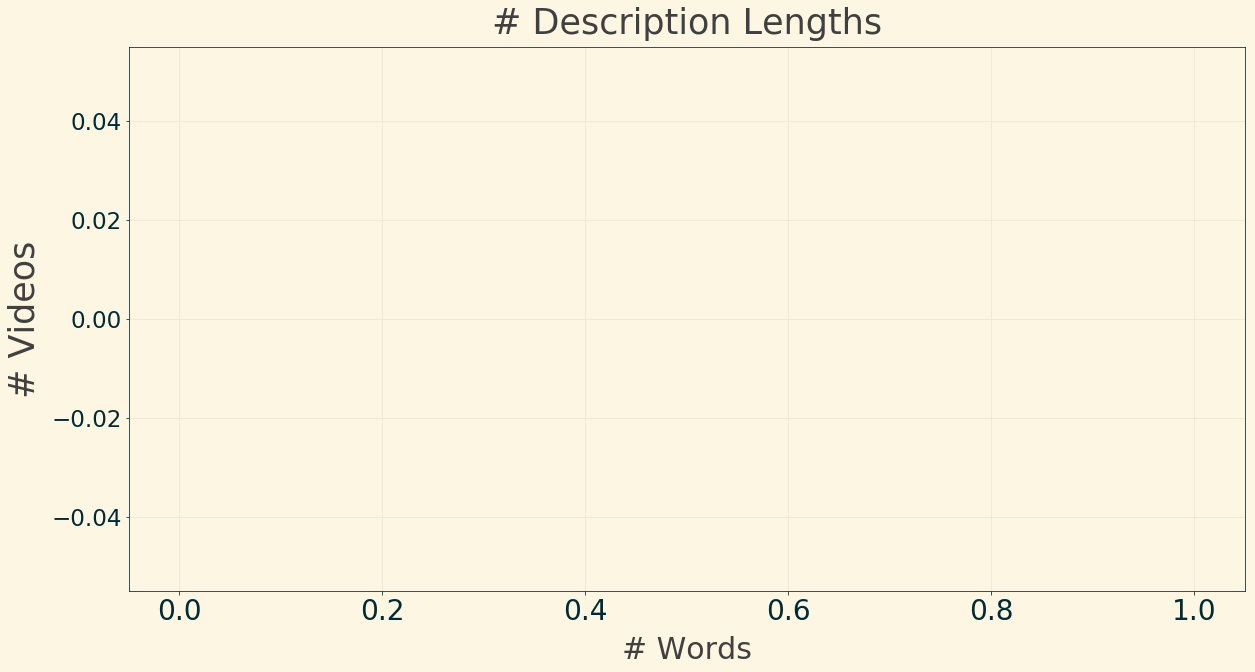

In [161]:
len_hist = st3_df['description_length'].hist(bins=20)
make_standard_fig(len_hist, fig_labels)

In [162]:
st3_df.sort_values('description_length').head(50)

,action_description,asgmt_id,gif_uri,hit_id,image_id,worker_id,description_length
0,Barney is scared by a large orange claw coming...,3BV8HQ2ZZX1SJVMTX82JWO3U1WP6A9,https://s3-us-west-2.amazonaws.com/ai2-vision-...,3EAWOID6MUXEAO5IGC8WUQCVMPG0VO,s_05_e_09_shot_032756_032830,A1B22TUTP9XR1D,NaN
1,Old Sheriff man is sitting at a table in the d...,3TMFV4NEP9ECUM8KRSV9YRWCZAFW8T,https://s3-us-west-2.amazonaws.com/ai2-vision-...,3OB6JN3A9RPJKVV8WXQKRQU54M5MRT,s_02_e_02_shot_010182_010256,A11XGDVL8AQ6VL,NaN
2,Fred and barney stand in the doorway to the ho...,3KGTPGBS6YLOG3HQGB776CYCSUE2UZ,https://s3-us-west-2.amazonaws.com/ai2-vision-...,3IHWR4LC7EDR67QLC9MS8GSJXLWI8W,s_02_e_07_shot_009401_009475,A2DRV5CGGW5HTK,NaN
3,Wilma and Fred are standing by the doorway. Wi...,3GA6AFUKOPO8WZ7PKCED67EE4043H2,https://s3-us-west-2.amazonaws.com/ai2-vision-...,3V7ICJJAZBGG0YPDUW4Y5H8109FB48,s_03_e_02_shot_033009_033083,AAI32CU3ZUGGV,NaN
4,Wilma is in a bedroom. She is crying in bed. ...,3TVSS0C0E20VS608UQ64PNSZDNVWTD,https://s3-us-west-2.amazonaws.com/ai2-vision-...,39TX062QX2O2V59AZERXK97N5C7X3I,s_03_e_19_shot_041459_041533,A39AXTTH0QVFA3,NaN
5,Barney is outside. His head is wrapped up and...,3VP0C6EFSHWTLWVIUBSO5FYUVDBM66,https://s3-us-west-2.amazonaws.com/ai2-vision-...,3EHIMLB7F8ZRACF16R4784R4X8I8HU,s_03_e_12_shot_012232_012306,A39AXTTH0QVFA3,NaN
6,A purple dino is standing in the backyard and ...,32RIADZIST4I4449VKVVKQDMRBL4SD,https://s3-us-west-2.amazonaws.com/ai2-vision-...,37VUR2VJ6BPII4K0LEHRI37G6A61CT,s_05_e_01_shot_023023_023097,AAI32CU3ZUGGV,NaN
7,A man in orange tunic is walking in the street...,37WLF8U1WQQYV8VF9ZF8Q26Q68C6KH,https://s3-us-west-2.amazonaws.com/ai2-vision-...,3X0EMNLXEQPHY592XXNM9RD3UXRPVJ,s_01_e_07_shot_027419_027493,A164LU3V7YITK7,NaN
8,Fred walks up to creepella gruesome in the roo...,3JBT3HLQF921U9C6OWHRJHLK5MIZP5,https://s3-us-west-2.amazonaws.com/ai2-vision-...,3XBXDSS889JJB9ZZ5KVXGV145YZLXL,s_05_e_09_shot_041787_041861,A37X1GHLB2HCX7,NaN
9,Fred stands behind a lady in a blue dress who ...,3U0SRXB7CE5SPXE2Y0AMTPEQWQVRN5,https://s3-us-west-2.amazonaws.com/ai2-vision-...,3421H3BM9BHNFNT1ZJD6KD2UU62J9X,s_06_e_23_shot_012023_012097,A4UVNGSXE2ANA,NaN


In [163]:
st3_df['setting'] = st3_df['image_id'].apply(lambda x: stage_3b_beta_locs[x])
st3_df['characters'] = st3_df['image_id'].apply(lambda x: [c['characterName'] for c in ds_by_frame[x]['characters']])

In [164]:
# st3_df['char_name'] = st3_df['image_id'].apply(lambda x:[char['characterName'] for char in ds_by_frame[x]['characters']])

In [165]:
st3_df.shape

(8504, 9)

In [166]:
st3_df.sample(100)[['image_id', 'gif_uri', 'action_description', 'setting', 'characters']].to_csv('stage3b_prod_2_100_sample.csv', index=False)

In [167]:
descript_df =  st3_df[['image_id', 'action_description']]
descript_df.index = descript_df['image_id']
pickle_this(descript_df['action_description'].to_dict(), 'stage3_prod1_2_descriptions.pkl')

In [168]:
# pickle_this(setting_lookup.to_dict(), 'stage_3_beta_gold_settings.pkl')

# 3. region experiment

In [169]:
def lookup_region(hitid):
    if hitid in nzaucaus_hit_ids:
        return 'nzaucaus'
    if hitid in us_hit_ids:
        return 'us only'
    if hitid in in_hit_ids:
        return 'in only'

In [170]:
# st3_df['region'] = st3_df['hit_id'].apply(lookup_region)

In [171]:
st3_df.head(1)

,action_description,asgmt_id,gif_uri,hit_id,image_id,worker_id,description_length,setting,characters
0,Barney is scared by a large orange claw coming...,3BV8HQ2ZZX1SJVMTX82JWO3U1WP6A9,https://s3-us-west-2.amazonaws.com/ai2-vision-...,3EAWOID6MUXEAO5IGC8WUQCVMPG0VO,s_05_e_09_shot_032756_032830,A1B22TUTP9XR1D,NaN,doorway,[barney]


In [172]:
grouped_by_image = st3_df.groupby('image_id')

In [173]:
st3_df[['image_id', 'gif_uri', 'action_description']].to_csv('stage_3b_beta_1.csv')

In [174]:
settings_per_turker = grouped_by_image['setting_description'].apply(lambda x: pd.Series(x.values)).unstack()
settings_per_turker = settings_per_turker.reset_index()
settings_per_turker.columns = ['image_id'] + ['turker{}  setting: '.format(i) for i in range(1, 4)]

KeyError: 'Column not found: setting_description'

In [ ]:
# settings_per_turker

In [ ]:
# settings_per_region = grouped_by_image['setting_description'].apply(lambda x: pd.Series(x.values)).unstack()
# actions_per_region = grouped_by_image['character_description'].apply(lambda x: pd.Series(x.values)).unstack()
# region_s = grouped_by_image['region'].apply(lambda x: pd.Series(x.values)).unstack()

# region_cols = region_s.iloc[0][[0, 1, 2]].values.tolist()

# settings_per_region.columns = ['setting: ' + reg for reg in region_cols]
# actions_per_region.columns = ['actions: ' + reg for reg in region_cols]
# settings_per_region = settings_per_region.reset_index()
# actions_per_region = actions_per_region.reset_index()

In [ ]:
gif_uris = grouped_by_image['gif_uri'].agg(np.max)

In [ ]:
# settings_per_turker

In [ ]:
beta_reponses_df = pd.merge(pd.DataFrame(gif_uris).reset_index(), settings_per_turker)

In [ ]:
beta_reponses_df

In [ ]:
# per_region_df['char_name'] = per_region_df['image_id'].apply(lambda x: ds_by_frame[x]['characters'][0]['characterName'])

In [ ]:
# pickle_this(set(per_region_df['image_id'].tolist()), 'random_sample_ids.pkl')

In [ ]:
beta_reponses_df.to_csv('stage_3b_beta_1.csv')

In [ ]:
# annotations_by_frame = defaultdict(list)
# for anno in sorted(assignment_results, key=lambda x: x['stillID']):
#     animation_id = anno['stillID'].rsplit('_', 1)[0]
#     annotations_by_frame[animation_id].append(anno)

# 4. parsing experiments

## combined

In [24]:
from phrase_cues.parsing import parse_description
import nltk

In [25]:
st3_df.shape

(8504, 6)

In [26]:
# desc_parses = st3_df['action_description'].apply(parse_description)

In [27]:
# dn = 0
dn = 20
test_doc = st3_df.iloc[dn]['action_description']

In [28]:
st3_df.iloc[dn]

action_description    Wilma is in a room.  She is talking on the pho...
asgmt_id                                 3AUQQEL7U6THX83C6EDYJA7G93YV0S
gif_uri               https://s3-us-west-2.amazonaws.com/ai2-vision-...
hit_id                                   37S0QRNUFCGYH1E83NA1VRY5UPR88E
image_id                                   s_04_e_05_shot_032472_032546
worker_id                                                A29RJVVL54THB5
Name: 20, dtype: object

In [29]:
parse_components = parse_description(test_doc)

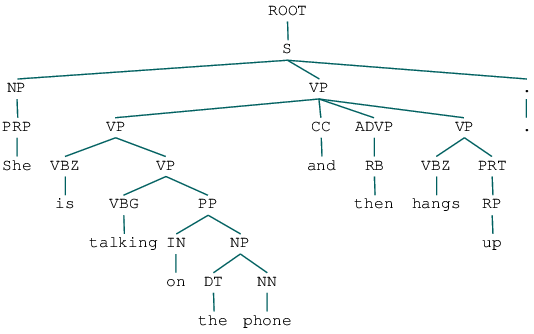

In [30]:
sent_1 = parse_components['constituent_parse'][1]
sent_1

In [34]:
traverseTree(sent_1)

She
is
talking
on
the
phone
and
then
hangs
up
.


In [69]:
st5 = list(sent_1.subtrees())[5]

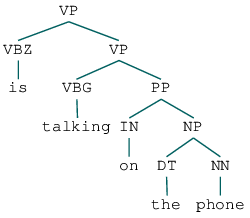

In [77]:
st5.

In [64]:
s = '(ROOT (S (NP (NNP Europe)) (VP (VBZ is) (PP (IN in) (NP (DT the) (JJ same) (NNS trends)))) (. .)))'
tree = nltk.tree.Tree.fromstring(s)
def traverseTree(tree):
    for subtree in tree:
        if type(subtree) == nltk.tree.Tree:
            print(subtree.label())
            print(subtree)
            traverseTree(subtree)
        else:
            pass


In [65]:
traverseTree(tree)

S
NP
NNP
VP
VBZ
PP
IN
NP
DT
JJ
NNS
.


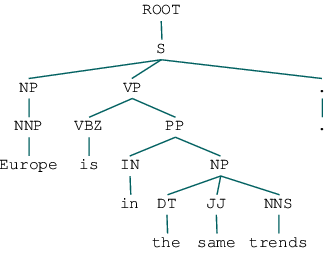

In [53]:
tree

In [ ]:
nps = parse_components['noun_phrase_chunks'][0]

## hide

In [ ]:
tree.

In [283]:
st5 = list(parented_tree.subtrees())[2]

In [284]:
len(list(st5.subtrees()))

2

In [147]:
st5.treeposition()

[(), (0,), (0, 0), (1,), (1, 0), (2,), (2, 0)]

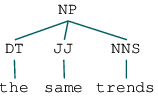

In [146]:
st5

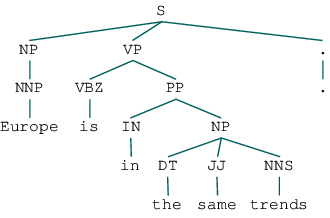

In [145]:
parented_tree[0]

In [ ]:
parented_tree.parent_index()

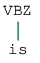

In [133]:
list(st5.subtrees())[0]

In [543]:
def build_simple_parse_tree(nltk_sent):
    
    return

def traverse_tree(tree):
    for subtree in tree.subtrees():
        if isinstance(subtree, Tree):
            traverseTree(subtree)
        else:
            print(subtree.leaves())
            
def get_tree_position(node):
    if node:
        return str(node.treeposition())
    else:
        return


class Tree(object):
    def __init__(self, nltk_parented_tree):
        self.subtrees = []
        self._node_lookup = {}
        self.leaves = []
        for node in list(nltk_parented_tree.subtrees()):
            nkey = str(node.treeposition())
            if len(node.leaves()) > 1 or len(list(node.subtrees())) > 1:
                self.subtrees.append(Node(node))
            else:
                node.set_label(' '.join([node.label(), node.leaves()[0]]))
                leaf_node = Node(node)
                self.subtrees.append(leaf_node)
                self.leaves.append(leaf_node)
            self._node_lookup[nkey] = self.subtrees[-1]
            
        self.root_node = [node for node in self.subtrees if node.value == 'ROOT'][0]
        self.word_pos_to_node = {idx: node for idx, node in enumerate(self.leaves)}
        
        for node in self.subtrees:
            node.left_sibling = self._node_lookup.get(node.left_sibling)
            node.right_sibling = self._node_lookup.get(node.right_sibling)
            node.parent = self._node_lookup.get(node.parent)


class Node(object):
    def __init__(self, nltk_node):
        self.value = nltk_node.label()  # (tag,word/phrase)
        self.left_sibling = get_tree_position(nltk_node)  # Instance of class Node
        self.right_sibling = get_tree_position(nltk_node)  # Instance of class Node
        self.parent = get_tree_position(nltk_node.parent()) # Instance of class Node

In [544]:
parented_tree = nltk.tree.ParentedTree.convert(sent_1)

In [545]:
test_tree = Tree(parented_tree)

In [548]:
import dill


with open('tree_format_example_dill.pkl', 'wb') as f:
    dill.dump(test_tree, f)

In [518]:
tt = [tp.treeposition() for tp in list(parented_tree.subtrees())][5]

In [519]:
str(tt)

'(0, 1, 0)'

In [521]:
tsn.height()

2

In [522]:
[t.value for t in test_tree.subtrees]

['ROOT',
 'S',
 'NP',
 'PRP She',
 'VP',
 'VP',
 'VBZ is',
 'VP',
 'VBG talking',
 'PP',
 'IN on',
 'NP',
 'DT the',
 'NN phone',
 'CC and',
 'ADVP',
 'RB then',
 'VP',
 'VBZ hangs',
 'PRT',
 'RP up',
 '. .']

In [523]:
rn = parented_tree.root()

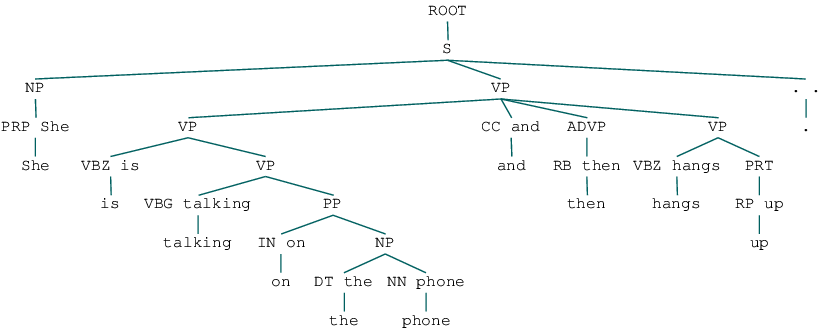

In [524]:
list(rn.subtrees())[0]

In [525]:
Node(st5)

In [526]:
sent_1.productions()

[ROOT -> S,
 S -> NP VP .,
 NP -> PRP,
 PRP -> 'She',
 VP -> VP CC ADVP VP,
 VP -> VBZ VP,
 VBZ -> 'is',
 VP -> VBG PP,
 VBG -> 'talking',
 PP -> IN NP,
 IN -> 'on',
 NP -> DT NN,
 DT -> 'the',
 NN -> 'phone',
 CC -> 'and',
 ADVP -> RB,
 RB -> 'then',
 VP -> VBZ PRT,
 VBZ -> 'hangs',
 PRT -> RP,
 RP -> 'up',
 . -> '.']

In [ ]:
traverse_tree(sent_1)a

In [ ]:
build_simple_parse_tree(sent_1)

In [ ]:
list(sent_1.subtrees())

In [ ]:
tagged_parse_sents

In [ ]:
cps1

In [ ]:
parse_components['constituent_parse']

In [ ]:
for t in cps1:
    if isinstance(t, Tree):
        print('h')
    else:
        print('t')
        

In [ ]:
tree = Tree('scores',
            [Tree('extent', ['highest']),
             Tree('filler',
                  [Tree('filler', ['scores']),
                   Tree('filler', ['for'])]),
             Tree('team', ['India'])])

In [ ]:
from nltk import Tree

def tree_to_dict(tree):
    return {t: [tree2dict(t)  if isinstance(t, Tree) else t for t in tree]}

In [ ]:
# pickle_this(desc_parses.to_dict(), 'stage3_prod1_2_descriptions_parses.pkl')

In [ ]:
cps1[0]

In [205]:
def traverseTree(tree):
    #print("tree:", tree)
    for subtree in tree:
        if type(subtree) == nltk.tree.ParentedTree:
#             print(subtree)
            traverseTree(subtree)
        else:
            print(subtree)

In [206]:
traverseTree(parented_tree)

Europe
is
in
the
same
trends
.


In [ ]:
gp1 = tree.productions()[0]

In [ ]:
# tree_to_dict(tree)

In [ ]:
d = tree_to_dict(cps1)
json.dumps(d , indent=4)

### insert coref sample

In [ ]:
c1 = ['Barney', 'Barney']
c2 =  ['a large orange claw coming in through the doorway', 'it']
c3 =  ['a large orange claw', 'the claw']

In [ ]:
spacy.

## pos tagging

In [ ]:
import spacy
nlp = spacy.load('en')

In [ ]:
test_doc = st3_df.iloc[0]['action_description']

In [ ]:
st3_df['action_description'][1]

In [ ]:
doc

In [ ]:
doc = nlp(test_doc)
for word in doc:
    print(word.text, word.lemma, word.lemma_, word.tag, word.tag_, word.pos, word.pos_)

In [ ]:
doc

## np chunks

In [ ]:
for npc in doc.noun_chunks:
    print(npc.text)

In [ ]:
# from spacy.symbols import *

# np_labels = set([nsubj, nsubjpass, dobj, iobj, pobj]) # Probably others too
# def iter_nps(doc):
#     for word in doc:
#         if word.dep in np_labels:
#             yield word.subtree

# [list(x)[0] for x in list(iter_nps(doc))]

## const parse

In [ ]:
import os

In [ ]:
from nltk.parse.stanford import StanfordParser
from nltk.draw.tree import TreeView

In [ ]:
core_nlp_base = '/Users/schwenk/wrk/animation_gan/build_dataset/parsing/stanford_core_nlp/stanford-corenlp-full-2017-06-09/'

In [ ]:
parser = StanfordParser(path_to_jar=core_nlp_base + 'stanford-corenlp-3.8.0.jar', path_to_models_jar=core_nlp_base + 'stanford-corenlp-3.8.0-models.jar')

In [ ]:
sentences = parser.raw_parse_sents(("Hello, My name is Melroy.", "What is your name?"))

In [ ]:
TreeView(sentences)._cframe.print_to_file('tree.ps')

In [ ]:
psent = [list(i)[0] for i in sentences]

In [ ]:
first_sent = psent[0][0]

In [ ]:
first_sent.draw()

In [ ]:
psent[1][0]

In [ ]:
TreeView(first_sent)._cframe

In [ ]:
TreeView(first_sent)._cframe.
_ = os.system('convert tree.ps tree.png')

In [ ]:
# GUI
for line in sentences:
    for sentence in line:
        sentence.draw()._cframe.print_to_file('tree.ps')
        _ = os.system('convert tree.ps tree.png')

In [ ]:
TreeView(sentences)._cframe.print_to_file('tree.ps')

### hide

In [ ]:
from corenlp import CoreNLPClient

In [ ]:
%env JAVANLP_HOME=/Users/schwenk/wrk/animation_gan/build_dataset/parsing/stanford_core_nlp/stanford-corenlp-full-2017-06-09

In [ ]:
text = "Chris wrote a simple sentence that he parsed with Stanford CoreNLP."

In [ ]:
with CoreNLPClient(annotators="tokenize ssplit".split()) as client:
    ann = client.annotate(text)

In [ ]:
! echo $JAVANLP_HOME

## coref

In [ ]:
_ = """
Predicted cluster: ['Barney', 'Barney']
Predicted cluster: ['a large orange claw coming in through the doorway', 'it']
Predicted cluster: ['a large orange claw', 'the claw']
"""